# Load Python Packages & Data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To run all commands in a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr" # default
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
ratings = pd.read_csv('/kaggle/input/ratings.csv', usecols = ['userId', 'movieId', 'rating'])
tags = pd.read_csv('/kaggle/input/tags.csv')
movies = pd.read_csv('/kaggle/input/movies.csv')


movies.head()
ratings.head(20)
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


# Exploratory Data Analysis

In [3]:
# Understand ratings
ratings.describe(include='all')

# Check for null values
movies.isnull().sum()
ratings.isnull().sum()
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [4]:
InteractiveShell.ast_node_interactivity = "last_expr"

# Check for duplicates in movies; if they exist, show the duplicates
if movies['title'].nunique() != movies.shape[0]:
    movies[movies.duplicated(['title'], keep=False)]
    
# I am surprised by these duplicates as the movieIds are different :O
# Decide what to do with the duplicates - remove the redundant rows
movies = movies[movies['movieId'] != 64997]
movies = movies[movies['movieId'] != 65665]

NameError: name 'InteractiveShell' is not defined

In [5]:
# Check if an user rated the same movie more than once - if yes, drop them
# ratings2 = ratings.drop_duplicates(['userId', 'movieId'])

# Checking if any duplicates were dropped or not - luckily, no duplicates, hence we comment this cell
# ratings2.shape[0] == ratings.shape[0]

# We don't check duplicates in tags df as a movie can have multiple tags.
# The data looks like one tag in each row and this is not a problem at the moment.

In [6]:
# Count the number of movies with each rating
ratings.groupby('rating')['movieId'].nunique()

rating
0.5     868
1.0    1959
1.5    1204
2.0    3130
2.5    2409
3.0    4771
3.5    3612
4.0    5141
4.5    2454
5.0    3127
Name: movieId, dtype: int64

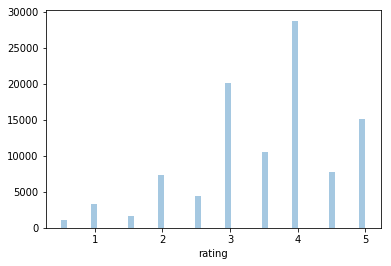

In [7]:
# Plot a histogram showing the distribution of movie ratings
sns.distplot(ratings['rating'], kde = False);
# We see that users mostly leave a rating of 4 if they like the movie.

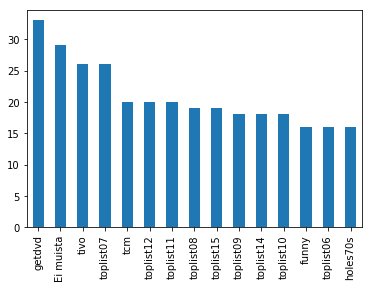

In [8]:
# Plot the number of movies with a particular tag for the first 15 tags
tag_counts = tags['tag'].value_counts()
tag_counts[:15].plot(kind='bar');

In [9]:
# Count the number of movies
movies['movieId'].count()

9125

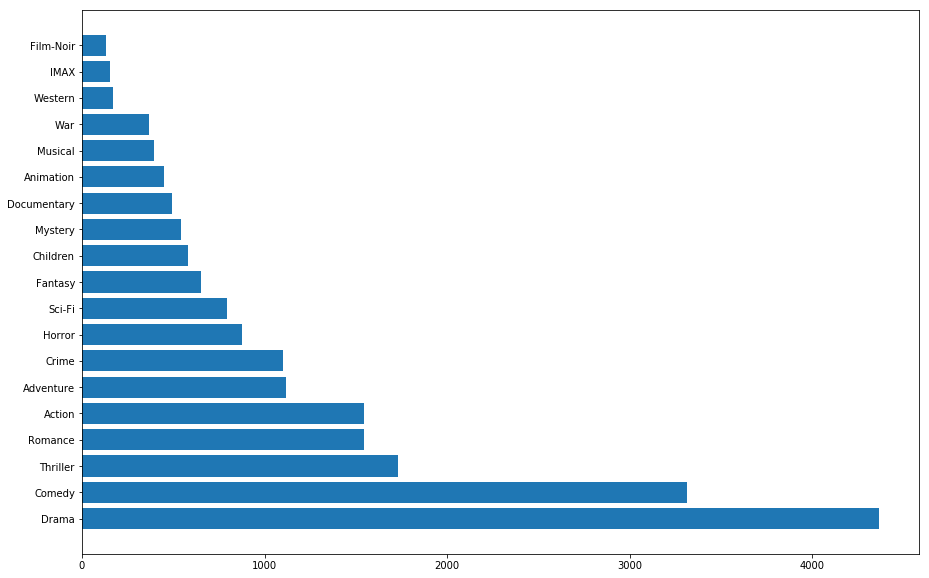

In [10]:
# Analysis of different genres
# Removing NaN values

# Check if all movies have genres listed - 
# For this we list out all unique genres

# Split the genres column values
f = lambda x: x["genres"].split("|")
buf = movies.apply(f, axis = 1)

# Count the number of each unique genre - can also use unique() instead of value_counts() to display the unqiue genres
# we use value_counts() as we want to plot this data
df = buf.apply(pd.Series).stack().value_counts().to_frame()
df.reset_index(inplace = True)
df.columns = ['genre', 'count']

# Since we see that some movies have no genres listed, we delete these movies
df = df[df.genre != '(no genres listed)']

# Plot a bar chart to see the most popular genre among the viewers
fig, ax = plt.subplots(figsize=(15,10))
plt.barh(df['genre'], df['count']);

# We see that 'Drama' is most popular followed by 'Comedy'.

## Euclidean Distance Score

Euclidean distance is the square root of the sum of squared differences between corresponding elements of the two vectors. Euclidean distance is only appropriate for data measured on the same scale.

euclidean_distance = 1/(1 + sqrt of sum of squares between two points)
Clearly, this value varies between 0 to 1, where closeness to 1 implies greater similarity.

In [11]:
def euclidean_distance(pid1, pid2):
    
    # Get details of pids 1 and 2
    df_first = ratings.loc[ratings['userId'] == pid1]
    df_second = ratings.loc[ratings['userId'] == pid2]
    
    # Find similar movies for pids 1 and 2
    df = pd.merge(df_first, df_second, how = 'inner', on = 'movieId')
    
    # If no similar movie found, return 0 (no similarity)
    if (len(df) == 0):
        return 0
    
    # Compute the sum of squared differences between ratings
    sum_of_squares = sum(pow((df['rating_x'] - df['rating_y']), 2))
    return 1 / (1 + sum_of_squares)

# Test the function: correlation should be 1
euclidean_distance(1,1)

1.0

## Pearson Correlation Score

* Correlation between sets of data is a measure of how well they are related. It shows the linear relationship between two sets of data. In simple terms, it answers the question, Can I draw a line graph to represent the data?

* Value varies between -1 to 1 with 0 implying no relation, -1 implying perfect negative correlation and 1 implying perfect positive correlation.



In [12]:
def pearson_score(pid1, pid2):
    
    # Get rating activity for pids 1 and 2
    df_first = ratings.loc[ratings.userId == pid1]
    df_second = ratings.loc[ratings.userId == pid2]
    
    # Get mutually rated items    
    df = pd.merge(df_first, df_second, how = 'inner', on = 'movieId')
    
    # Check if they have common ratings
    if (len(df) == 0):
        return 0

    else:
        # Add up all the ratings
        sum1 = sum(df['rating_x'])
        sum2 = sum(df['rating_y'])
    
        # Sum up squares of ratings
        sum1_square = sum(pow(df['rating_x'], 2))
        sum2_square = sum(pow(df['rating_y'], 2))
    
        # Calculate the sum of products
        product_sum = sum(df['rating_x'] * df['rating_y'])
    
        # Calculate the Pearson Score
        numerator = product_sum - (sum1 * sum2 / len(df))
        denominator = math.sqrt((sum1_square- pow(sum1, 2) / len(df)) * (sum2_square - pow(sum2, 2) / len(df)))
    
        if denominator == 0:
            return 0
    
        else:
            return numerator / denominator

# Checking function by passing similar ID, Output should be 1
pearson_score(1,1)

1.0

## Getting results based on Pearson score

In [13]:
# Gets recommendations for a person by using a weighted average of every other user's rankings
def recommend(pid, similarity=pearson_score):
    
    totals = {} # a dictionary to contain the sum of product of movie ratings by other users multiplied by weight (similarity)
    simSums = {} # a dictionary to contain the sum of weights for all users who have rated a particular movie.
    
    # create a df of pid's ratings
    df_pid = ratings.loc[ratings['userId'] == pid]
    
    # iterate through the ids in the df of ratings provided by all but 'pid'
    for id in ratings.loc[ratings['userId'] != pid]['userId']:
        
        # compute the similarity score between pid and id
        sim = similarity(pid, id)
        
        # ignore a score of zero or negative correlation         
        if sim > 0:
            # create a df of rating by a particular id (note this id is not equal to pid)             
            df_other = ratings.loc[ratings['userId'] == id]
        
            # find movies not seen by pid
            moviedf = df_other[~df_other.movieId.isin(df_pid.movieId)]
            
            # 
            for movieid, rating in (np.array(moviedf[['movieId','rating']])):
                
                # similarity * rating
                totals.setdefault(movieid, 0)
                totals[movieid] += rating * sim
            
                # sum of similarities
                simSums.setdefault(movieid, 0)
                simSums[movieid] += sim
            
            # create a normalized list of tuples, [(score, id), ...]
            ranking = [(t / simSums[movieid], movieid) for movieid, t in totals.items()]
        
            # sort the list based on score
            ranking.sort()
            ranking.reverse()
            recommendedId = np.array([x[1] for x in ranking])
            
            # find the movie title and return top 5 recommendations
            return np.array(movies[movies['movieId'].isin(recommendedId)]['title'])[:5]

In [14]:
# Example recommendation
# Recommends top 5 movies for the given UserID
# userId ranges from 1 to 671
rec = recommend(671)
for movie in rec:
    print (movie)

GoldenEye (1995)
Sense and Sensibility (1995)
Clueless (1995)
Seven (a.k.a. Se7en) (1995)
Mighty Aphrodite (1995)
